# Separate optimization for the tour and the final impact

In [1]:
%matplotlib notebook

In [2]:
import pykep as pk
import pygmo as pg
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import gtocprep as g  # note that this is Mate's version available from https://github.com/mkisantal/gtoc-stuff
import math


In [3]:
V0 = 3000 # m/s
R0 = 1000 * g.RADIUS_SATURN # m
M0 = 5000 # kg
ISP = 308 # s
MPROP = 2000 # kg
T_START, T_END = 20000, 24000 # MJD2000
T_budget = 365.25

### Setting up bounds for tour

Here we optimize for the full sequence (including Enceladus), but without impact. We try to save fuel and time, so that we can spend it on impact later.

In [4]:
placeholder = g.titan  # it will get overwritten

seq = [placeholder, g.enceladus, g.titan, g.tethys, g.rhea, g.dione, g.enceladus]

t0 = [pk.epoch(23947), pk.epoch(23949)]

tof = [[204.328848, 204.328848], [34.51, 34.53], [1.9, 1.92], [18.19, 18.2], [20.11, 20.12], [15, 60]]
vinf = [3000, 3000] # m/s

anomaly = [28, 30]

etas = None  # equivalent to [0, 1] for all etas


### Optimizing the tour

In [5]:
udp = g.MgaDsm1Full(seq, t0, tof, vinf, anomaly,
                    add_vinf_dep=False, add_vinf_arr=False, multi_objective=False,
                    impact=False, mass=[M0-MPROP, M0], isp=ISP, cw=False,
                    etas=etas)
prob = pg.problem(udp)
uda = pg.algorithms.sade(memory=True)
alg = pg.algorithm(uda)
pop = pg.population(prob, 20)

In [6]:
for i in tqdm(list(range(10000))):
    try:
        pop = alg.evolve(pop)
    except RuntimeError:
        pass
dv = pop.champion_f[0]
veff = ISP * pk.G0
mf = M0 / np.exp(dv / veff)
print('DV: {0:0.3f}m/s, propellant used: {1:0.3f}kg'.format(dv, M0 - mf))


DV: 1203.214m/s, propellant used: 1642.886kg


In [7]:
pop.champion_x

array([ 2.82940356e+01,  2.39482054e+04,  8.00027125e-01,  2.90457693e-01,
        3.00000000e+03,  6.82601689e-01,  2.04328848e+02,  2.16722697e+00,
        1.10000000e+00,  2.40764204e-03,  3.45230941e+01, -2.52054512e+00,
        6.39687353e+00,  8.66190060e-01,  1.91986273e+00,  1.34693836e+00,
        1.10000000e+00,  2.25230504e-01,  1.81999985e+01,  5.55670259e+00,
        1.73234836e+00,  6.56064983e-01,  2.01199586e+01,  5.41060141e-01,
        4.58471825e+00,  2.43787227e-01,  1.89918813e+01])

In [8]:
udp.pretty(pop.champion_x)

First leg: pseudo to enceladus
Departure: 2065-Jul-26 04:55:50.013988 (23948.205440 mjd2000)
Duration: 204.328848d
VINF: 3000.000m/s
DSM after 139.475217d
DSM magnitude: 17.596185m/s

leg 2: enceladus to titan
Duration: 34.523094d
Fly-by epoch: 2066-Feb-15 12:49:22.481188 (24152.534288 mjd2000)
Fly-by radius: 1.100000 planetary radii
DSM after 0.083119d
DSM magnitude: 694.671180m/s

leg 3: titan to tethys
Duration: 1.919863d
Fly-by epoch: 2066-Mar-22 01:22:37.811412 (24187.057382 mjd2000)
Fly-by radius: 6.396874 planetary radii
DSM after 1.662966d
DSM magnitude: 322.811314m/s

leg 4: tethys to rhea
Duration: 18.199998d
Fly-by epoch: 2066-Mar-23 23:27:13.951614 (24188.977245 mjd2000)
Fly-by radius: 1.100000 planetary radii
DSM after 4.099195d
DSM magnitude: 62.981400m/s

leg 5: rhea to dione
Duration: 20.119959d
Fly-by epoch: 2066-Apr-11 04:15:13.820919 (24207.177243 mjd2000)
Fly-by radius: 1.732348 planetary radii
DSM after 13.200000d
DSM magnitude: 103.227567m/s

leg 6: dione to encel

<IPython.core.display.Javascript object>


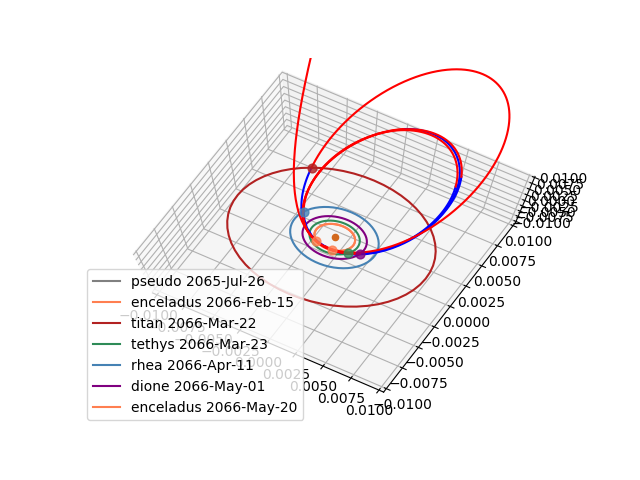

In [9]:
ax = udp.plot(pop.champion_x)
axlim = .01
ax.set_xlim3d(-axlim, axlim)
ax.set_ylim3d(-axlim, axlim)
ax.set_zlim3d(-axlim, axlim)
ax.view_init(elev=90, azim=90)
plt.show()

### Optimizing the impact leg

Right now it's just the final eta and time of flight. Will try to improve it later (e.g. pumping up semimajor axis in multiple manouvres, or even GA with moons).

In [10]:
impact_udp = g.ImpactLeg(pop.champion_x, [0, 30], [0,1], seq=seq, mass=[M0-MPROP, M0], isp=ISP)
impact_prob = pg.problem(impact_udp)
impact_uda = pg.algorithms.sade(memory=True)
impact_alg = pg.algorithm(impact_uda)
impact_pop = pg.population(impact_prob, 20)

In [11]:
for i in tqdm(list(range(1000))):
    try:
        impact_pop = impact_alg.evolve(impact_pop)
    except RuntimeError:
        pass

J = -impact_pop.champion_f[0]
dv = impact_udp.get_dv(impact_pop.champion_x)
veff = ISP * pk.G0
mf = M0 / np.exp(dv / veff)
print('Impact energy: {:0.3f}GJ, DV: {:0.3f}m/s, propellant used: {:0.3f}kg'.format(J, dv, M0 - mf))


Impact energy: 222.510GJ, DV: 1542.922m/s, propellant used: 2000.000kg


<IPython.core.display.Javascript object>


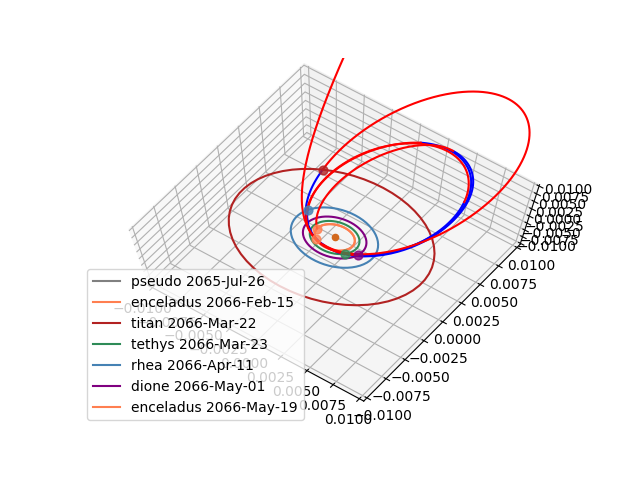

In [12]:
ax = impact_udp.plot(impact_pop.champion_x)
axlim = .01
ax.set_xlim3d(-axlim, axlim)
ax.set_ylim3d(-axlim, axlim)
ax.set_zlim3d(-axlim, axlim)
ax.view_init(elev=90, azim=90)
plt.show()

In [13]:
impact_udp.pretty(impact_pop.champion_x)

First leg: pseudo to enceladus
Departure: 2065-Jul-26 04:55:50.013988 (23948.205440 mjd2000)
Duration: 204.328848d
VINF: 3000.000m/s
DSM after 139.475217d
DSM magnitude: 17.596185m/s

leg 2: enceladus to titan
Duration: 34.523094d
Fly-by epoch: 2066-Feb-15 12:49:22.481188 (24152.534288 mjd2000)
Fly-by radius: 1.100000 planetary radii
DSM after 0.083119d
DSM magnitude: 694.671180m/s

leg 3: titan to tethys
Duration: 1.919863d
Fly-by epoch: 2066-Mar-22 01:22:37.811412 (24187.057382 mjd2000)
Fly-by radius: 6.396874 planetary radii
DSM after 1.662966d
DSM magnitude: 322.811314m/s

leg 4: tethys to rhea
Duration: 18.199998d
Fly-by epoch: 2066-Mar-23 23:27:13.951614 (24188.977245 mjd2000)
Fly-by radius: 1.100000 planetary radii
DSM after 4.099195d
DSM magnitude: 62.981400m/s

leg 5: rhea to dione
Duration: 20.119959d
Fly-by epoch: 2066-Apr-11 04:15:13.820919 (24207.177243 mjd2000)
Fly-by radius: 1.732348 planetary radii
DSM after 13.200000d
DSM magnitude: 103.227567m/s

leg 6: dione to encel